## **UCI Breast Cancer Wisconsin**

In [2]:
pip install ucimlrepo

In [39]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)


# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

In [7]:
print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [8]:
# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

In [9]:
# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

                  name     role         type demographic description units  \
0                   ID       ID  Categorical        None        None  None   
1            Diagnosis   Target  Categorical        None        None  None   
2              radius1  Feature   Continuous        None        None  None   
3             texture1  Feature   Continuous        None        None  None   
4           perimeter1  Feature   Continuous        None        None  None   
5                area1  Feature   Continuous        None        None  None   
6          smoothness1  Feature   Continuous        None        None  None   
7         compactness1  Feature   Continuous        None        None  None   
8           concavity1  Feature   Continuous        None        None  None   
9      concave_points1  Feature   Continuous        None        None  None   
10           symmetry1  Feature   Continuous        None        None  None   
11  fractal_dimension1  Feature   Continuous        None        

## **EDA-Exploratory Data Analysis**

['B' 'M']
[0 1]
Diagnosis
B    0.627417
M    0.372583
Name: count, dtype: float64


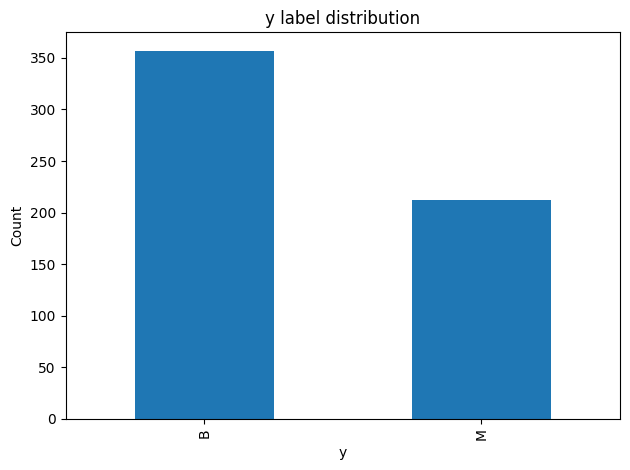

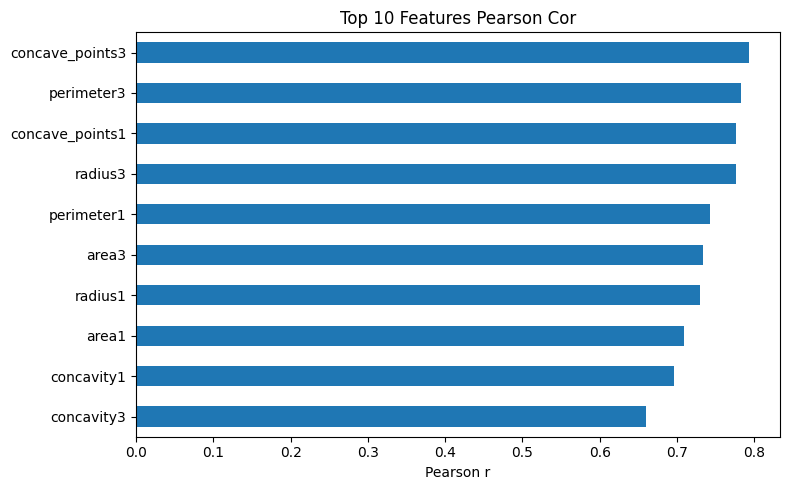

In [32]:
def rename_columns(X, y):
  y = y.squeeze()
  y.name = "Diagnosis"
  new_df = X.copy()
  new_df["Diagnosis"] = y
  return new_df, y

df, y = rename_columns(X, y)

# df.head()


le = LabelEncoder()
df["Diagnosis_Encoded"] = le.fit_transform(df["Diagnosis"])
print(le.classes_)                # ['B' 'M']
print(le.transform(le.classes_))   # [0 1]

counts = df["Diagnosis"].value_counts()
ratio = counts / counts.sum()
# print(counts)
print(ratio)
df["Diagnosis"].value_counts().plot.bar()
plt.title("y label distribution")
plt.xlabel("y")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

corr = df.corr(numeric_only=True)["Diagnosis_Encoded"]
top10 = corr.drop("Diagnosis_Encoded").nlargest(10)
def plt_top10(top10, size):
  plt.figure(figsize=size)
  top10.plot(kind="barh")
  plt.title("Top 10 Features Pearson Cor")
  plt.xlabel("Pearson r")
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()
plt_top10(top10, (8,5))

In [33]:
print(X.shape)
print(y.shape)
print(y[0])
print(df["Diagnosis"][0])
print(df["Diagnosis_Encoded"][0])

(569, 30)
(569,)
M
M
1


In [34]:
desc_stats = X.describe().T
# print(desc_stats)
print("Statistics of features")
print(desc_stats.round(3).to_string())

Statistics of features
                    count     mean      std      min      25%      50%       75%       max
radius1             569.0   14.127    3.524    6.981   11.700   13.370    15.780    28.110
texture1            569.0   19.290    4.301    9.710   16.170   18.840    21.800    39.280
perimeter1          569.0   91.969   24.299   43.790   75.170   86.240   104.100   188.500
area1               569.0  654.889  351.914  143.500  420.300  551.100   782.700  2501.000
smoothness1         569.0    0.096    0.014    0.053    0.086    0.096     0.105     0.163
compactness1        569.0    0.104    0.053    0.019    0.065    0.093     0.130     0.345
concavity1          569.0    0.089    0.080    0.000    0.030    0.062     0.131     0.427
concave_points1     569.0    0.049    0.039    0.000    0.020    0.034     0.074     0.201
symmetry1           569.0    0.181    0.027    0.106    0.162    0.179     0.196     0.304
fractal_dimension1  569.0    0.063    0.007    0.050    0.058    0.

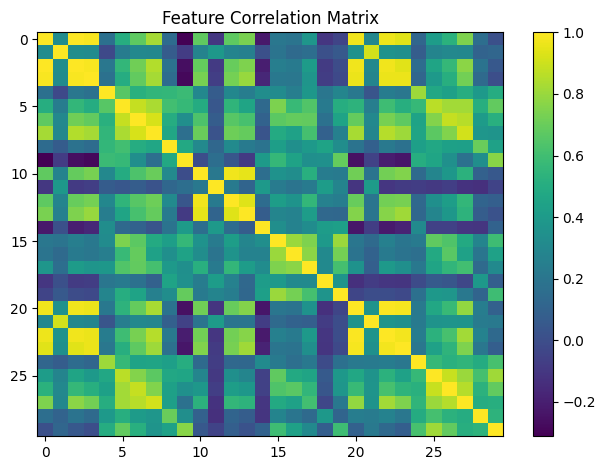

In [ ]:
plt.figure()   # feature correlation
plt.imshow(X.corr(), aspect="auto")
plt.title("Feature Correlation Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

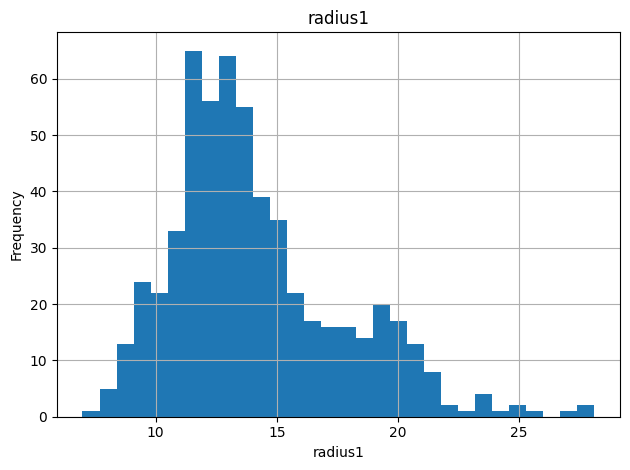

In [35]:
plt.figure()  # individual features - i.e radius1
X["radius1"].hist(bins=30)
plt.title("radius1")
plt.xlabel("radius1")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## **Data Preprocessing**

In [41]:
print(y[0])
print(df["Diagnosis_Encoded"][0])

M
1


In [42]:
y = df["Diagnosis_Encoded"] # encode y to 0 and 1
print(y[0])
print(y.shape)

1
(569,)


In [45]:
numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[
 ("normalization", StandardScaler())
])
preprocess = ColumnTransformer(
 transformers=[("normalization_numeric", numeric_transformer, numeric_features)]
)

def pipeline_builder(preprocess, model):
 steps = []
 steps.append(("preprocess", preprocess))
 steps.append(("rf_model", rf_model))
 pipeline = Pipeline(steps)
 return pipeline

rf_model = RandomForestClassifier(random_state=33)
pipeline = pipeline_builder(preprocess, rf_model)

## **Hyperparameter Search & Training & Testing**

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=33
)

param_dist = {
    "rf_model__n_estimators": range(100, 501, 100),
    "rf_model__max_depth": [None, 5, 10, 20],
    "rf_model__min_samples_split": [2, 4, 6],
    "rf_model__min_samples_leaf": [1, 2, 4],
    "rf_model__max_features": ["sqrt", "log2", None]
}
param_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_log_loss",  # BCE loss
    cv=5,
    n_jobs=-1,
    random_state=33,
    verbose=0
)

# training
def find_best(ps, X, Y):
  ps.fit(X, Y)
  return ps.best_estimator_

best_model = find_best(param_search, X=X_train, Y=y_train)

In [52]:
def pred_proba_label(model, X):
  pred = model.predict(X)
  proba = model.predict_proba(X)
  proba_M = proba[:, 1]
  return pred, proba_M
pred, proba = pred_proba_label(best_model, X_test)


def metrics(test, pred, proba):
  metrics = []
  accuracy = accuracy_score(test, pred)
  print("accuracy")
  print(accuracy)
  metrics.append(accuracy)
  prec = precision_score(test, pred, pos_label=1)
  metrics.append(prec)
  print("precision")
  print(prec)
  rc = recall_score(test, pred, pos_label=1)
  metrics.append(rc)
  print("recall")
  print(rc)
  F_one = f1_score(test, pred, pos_label=1)
  metrics.append(F_one)
  print("f1")
  print(F_one)
  logloss = log_loss(test, proba)
  metrics.append(logloss)
  print("logloss")
  print(logloss)
  return metrics


metrics_ar = []
metrics_ar = metrics(y_test, pred, proba)

accuracy
0.9122807017543859
precision
0.9
recall
0.8571428571428571
f1
0.8780487804878049
logloss
0.5165756323333287


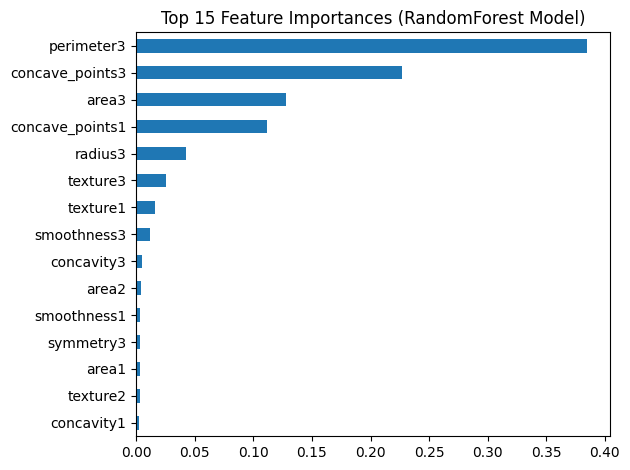

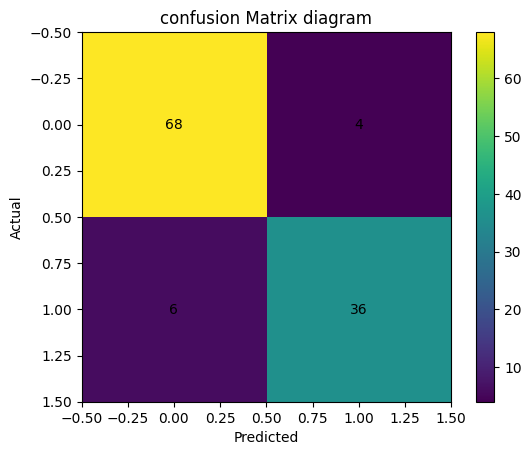

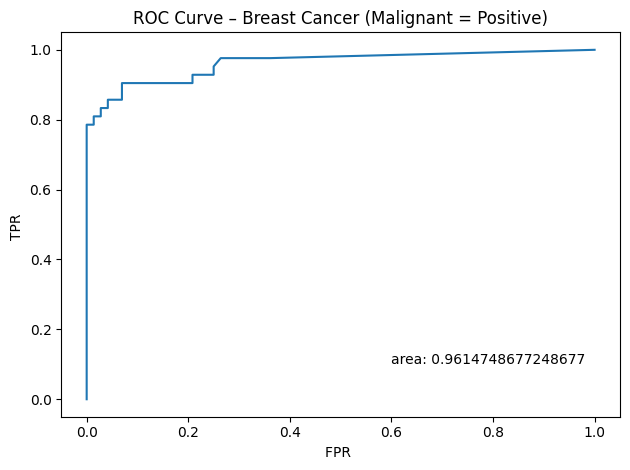

In [79]:
# final result analysis
def features(model, X):
  p = model.named_steps["rf_model"]
  featr = pd.Series(p.feature_importances_, index=numeric_features)
  top = featr.sort_values(ascending=False)
  plt.figure()
  top.head(15).plot(kind="barh")
  plt.gca().invert_yaxis()
  plt.title("Top 15 Feature Importances (RandomForest Model)")
  plt.tight_layout()
  plt.show()

def CMatrix(test, pred):
  cm = confusion_matrix(y_test, pred)
  plt.imshow(cm)
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          value = cm[i, j]
          plt.text(j, i, value, ha="center", va="center")

  plt.title("confusion Matrix diagram")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.colorbar()
  plt.show()

def roc(test, proba):
  area = roc_auc_score(y_test, proba)
  fpr, tpr, UNUSED = roc_curve(test, proba, pos_label=1)
  plt.figure()
  plt.plot(fpr, tpr)
  plt.text(0.6, 0.1, "area: "+str(area))
  plt.xlabel("FPR ")
  plt.ylabel("TPR ")
  plt.title("ROC Curve – Breast Cancer (Malignant = Positive)")
  plt.tight_layout()
  plt.show()


features(best_model, X_train)
CMatrix(y_test, pred)
roc(y_test, proba)
